## データの容量を調べる
duコマンドでデータの大きさを調べる


**参考**
https://eng-entrance.com/linux-command-du

In [1]:
!du -l ../csv/*

6136	../csv/sample_submission.csv
58948	../csv/test.csv
4864	../csv/test_labels.csv
67192	../csv/train.csv


In [2]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# LookupError対応
# 参考：http://vastee.hatenablog.com/entry/2018/06/21/154027
nltk.download('stopwords')

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv("../csv/train.csv")
test = pd.read_csv("../csv/test.csv")

### データの中身を確認
#### tail(末尾)
head - 最初から  
tail - 最後から

**参考記事**
https://note.nkmk.me/python-pandas-head-tail/

In [4]:
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


### train, testデータの割合を確認

In [5]:
nrow_train = train.shape[0]
nrow_test = test.shape[0]
sum = nrow_train + nrow_test

print("      : train  : test ")
print("rows  :", nrow_train, ":", nrow_test)
print("perc  :", round(nrow_train*100/sum), "    :",round(nrow_test*100/sum))

      : train  : test 
rows  : 159571 : 153164
perc  : 51     : 49


### クラスが均衡しているか確認

In [6]:
# 列の二番目以降を抽出(id, comment_textを除く) 
x = train.iloc[:,2:].sum()
rowsums = train.iloc[:, 2:].sum(axis=1)
train["clean"] = (rowsums==0)
train["clean"].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


### 欠損値があるかどうか確認

`fillna`
`inplace=True`  
もとのデータに反映させるるかどうか

In [7]:
print("Check for missing values in Train dataset")
null_check = train.isnull().sum()
print(null_check)

print("Check for missing values in Test dataset")
test_null_check = test.isnull().sum()
print(test_null_check)

print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


### データ可視化
プロットした図を見ると、かなり不均衡なのがわかる。

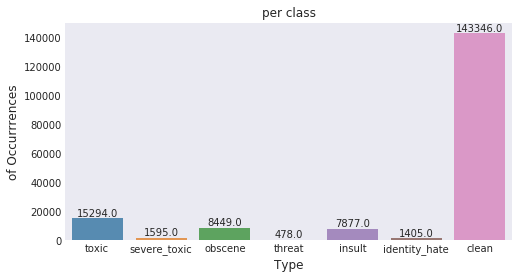

In [17]:
# バー
x = train.iloc[:, 2:].sum()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("per class")
plt.xlabel("Type", fontsize=12)
plt.ylabel("of Occurrrences", fontsize=12)

rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

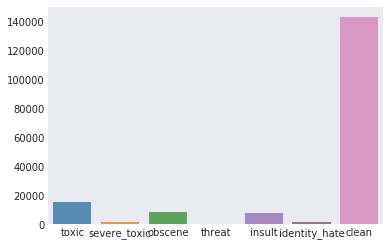

In [24]:
# seabornだけを使った可視化
# これだけで十分な気がする
sns.barplot(x.index, x.values, alpha=0.8);

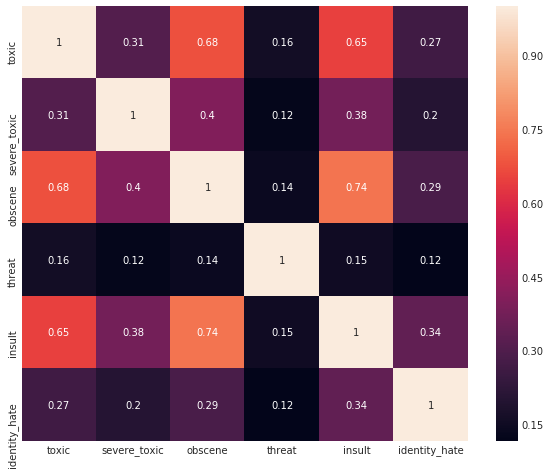

In [69]:
# ヒートマップ
# cleanを除き、相関関係を確認する
temp_df = train.iloc[:,2:-1]
corr = temp_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

# https://qiita.com/hiroyuki1990/items/00d0f52724f16ad7cf77

## 実際にデータを見てみる

In [70]:
print("toxic:")
print(train[train.toxic==1].iloc[35,1])
print("------")
print(train[train.toxic==1].iloc[1,1])

toxic:
God is dead
I don't mean to startle anyone but God is dead. We should not worry about him anymore. Just thought I would let everyone know. Well, goodbye and good luck with your newfound crisis of faith! 24.77.205.229
------
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [71]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[35, 1])

severe_toxic:
go to  die 

son of  bich


In [66]:
print("obscene:")
print(train[train.obscene==1].iloc[2,1])

obscene:
FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!


ひどい言葉が結構見られる....

## WordCloudで可視化

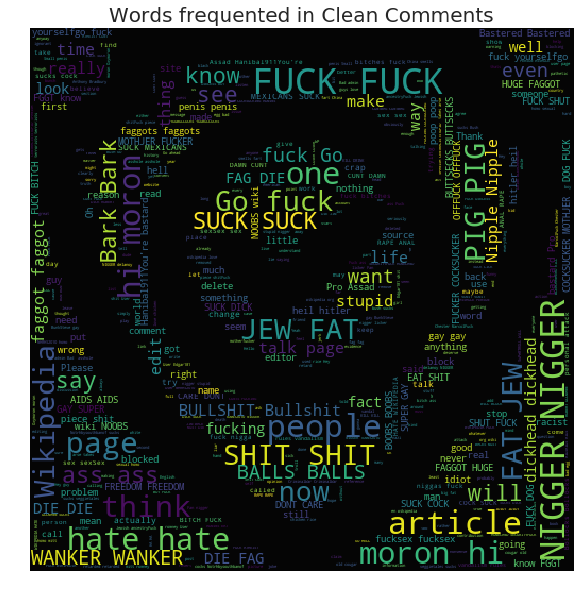

In [72]:
stopword=set(STOPWORDS)

#汚い言葉だけ
clean_mask=np.array(Image.open("image/safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==False]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

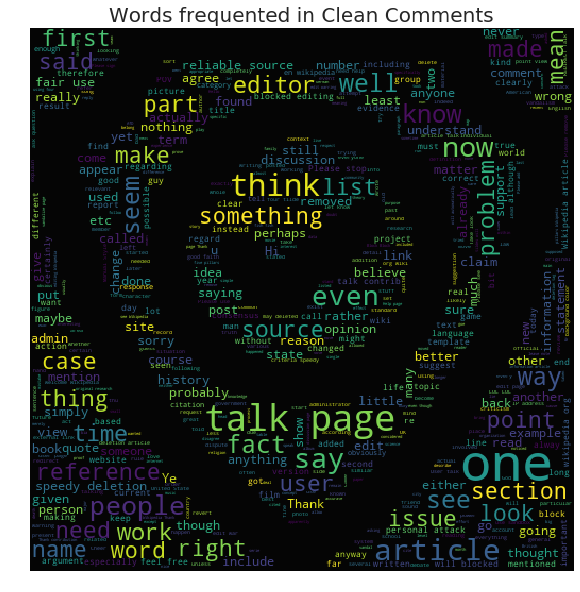

In [73]:
stopword=set(STOPWORDS)

#きいれいな言葉だけ
clean_mask=np.array(Image.open("image/safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()